<h2>PYSPARK #2: HYPERPARAMETERS TUNING</h2>

In a previous notebook we explored how to implement a model for a classification problem with Pyspark Python API; this exercise represents a step up, having the aim to implement <b>Hyperparameter Tuning</b>.</br>
Luckily the mllib library of Pyspark provides many tools for model estimation, here we'll use CrossValidator which allows the tuning of a whole estimator, i.e. a pipeline including both preprocessing and a ML algorithm.</br>
Once an estimator and a grid of hyperparameters is set, CrossValidator uses k-folds cross-validation, that is:
<ul>
<li>It splits the training data in a set of k subgroups of folds (by default 3)</li>
<li>For each set of hyperparameter it performs k training runs, each time using k-1 folds of training and one fold for validation.</li>
<li>The estimator performance is then the average of the k-runs, the best set of hyperparameters is then the one associated with the best average.</li>
</ul>

In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sentienttrapezoid","key":"a70cad3110e94349b766c9488ccd8252"}'}

In [2]:
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download rupindersinghrana/airbnb-price-dataset

Dataset URL: https://www.kaggle.com/datasets/rupindersinghrana/airbnb-price-dataset
License(s): apache-2.0
 58% 18.0M/31.3M [00:00<00:00, 84.0MB/s]
100% 31.3M/31.3M [00:00<00:00, 101MB/s] 


In [4]:
!unzip airbnb-price-dataset.zip

Archive:  airbnb-price-dataset.zip
  inflating: Airbnb_Data.csv         


In [5]:
!ls

Airbnb_Data.csv  airbnb-price-dataset.zip  kaggle.json	sample_data


We'll face the regression problem of predicting Airbnb price on major US cities.

In [6]:
from pyspark.sql import SparkSession
import pyspark.pandas as ps
import pyspark.sql.functions as F
import itertools
from pyspark.sql.types import StructType, StructField, IntegerType, LongType, StringType, FloatType, BooleanType, DateType
from pyspark.sql.functions import col, isnan, when, count, udf, round
from pyspark.ml.stat import Correlation
import pyspark.ml.feature as MFT
import pyspark.ml.functions as MF
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.regression import LinearRegression, RandomForestRegressor, GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time
from IPython.display import display

/usr/local/lib/python3.11/dist-packages/pyspark/pandas/__init__.py:50: UserWarning: 'PYARROW_IGNORE_TIMEZONE' environment variable was not set. It is required to set this environment variable to '1' in both driver and executor sides if you use pyarrow>=2.0.0. pandas-on-Spark will set it for you but it does not work if there is a Spark context already launched.
  warnings.warn(


In [7]:
spark = SparkSession.builder.master("local[*]").appName('airbnb').getOrCreate()

In [8]:
pdf = pd.read_csv('Airbnb_Data.csv')
df = ps.from_pandas(pdf).to_spark()
df.printSchema()

root
 |-- id: long (nullable = false)
 |-- log_price: double (nullable = false)
 |-- property_type: string (nullable = false)
 |-- room_type: string (nullable = false)
 |-- amenities: string (nullable = false)
 |-- accommodates: long (nullable = false)
 |-- bathrooms: double (nullable = true)
 |-- bed_type: string (nullable = false)
 |-- cancellation_policy: string (nullable = false)
 |-- cleaning_fee: boolean (nullable = false)
 |-- city: string (nullable = false)
 |-- description: string (nullable = false)
 |-- first_review: string (nullable = true)
 |-- host_has_profile_pic: string (nullable = true)
 |-- host_identity_verified: string (nullable = true)
 |-- host_response_rate: string (nullable = true)
 |-- host_since: string (nullable = true)
 |-- instant_bookable: string (nullable = false)
 |-- last_review: string (nullable = true)
 |-- latitude: double (nullable = false)
 |-- longitude: double (nullable = false)
 |-- name: string (nullable = false)
 |-- neighbourhood: string (null

/usr/local/lib/python3.11/dist-packages/pyspark/pandas/utils.py:1016: PandasAPIOnSparkAdviceWarning: If `index_col` is not specified for `to_spark`, the existing index is lost when converting to Spark DataFrame.
  warnings.warn(message, PandasAPIOnSparkAdviceWarning)


We perform a random split to create a traing and test DataFrame:

In [9]:
(train, test) = df.randomSplit([0.7, 0.3], seed = 7)
TRAIN_SIZE = train.count()
TEST_SIZE = test.count()
print('Train size: ', TRAIN_SIZE)
print('Test size: ', TEST_SIZE)

Train size:  51961
Test size:  22150


In [10]:
train.show(5, truncate = False)

+----+-----------------+-------------+---------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+---------+-------------+-------------------+------------+----+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<h3>Missing Values</h3>

Checking for Null values we notice features that have up to $\sim$ 25% of missing entries:

In [11]:
missing_vals = train.select([round( (100/TRAIN_SIZE) * count(when(col(c).isNull() |
                         #isnan(c) |
                         (col(c) == '') |
                         col(c).contains('None') |
                         col(c).contains('NULL'), c)), 2).alias(c) for c in train.columns])
missing_vals.show(truncate = False)

+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+----+-----------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+--------+---------+----+-------------+-----------------+--------------------+-------------+-------+--------+----+
|id |log_price|property_type|room_type|amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|city|description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|latitude|longitude|name|neighbourhood|number_of_reviews|review_scores_rating|thumbnail_url|zipcode|bedrooms|beds|
+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+----+-----------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+--------+---------+----+-------

To find out how these missing values are distributed in the DataFrame we check how many rows have no missing values; if the latter are mostly overlapping we would still have a significant portion of the DataFrame "clean" and we could argue for simply drop the remainder:

In [12]:
print('Percentage of rows with no missing values: ', np.round(100 *train.dropna().count()/TRAIN_SIZE, 2), '%')

Percentage of rows with no missing values:  51.98 %


Since almost half the DataFrame have at least one missing value we actually have to think of an imputation method.

The same check on the testing DataFrame shows a similar distribution of missing values:

In [ ]:
missing_vals_test = test.select([round( (100/TEST_SIZE) * count(when(col(c).isNull() |
                         #isnan(c) |
                         (col(c) == '') |
                         col(c).contains('None') |
                         col(c).contains('NULL'), c)), 2).alias(c) for c in test.columns])
missing_vals_test.show(truncate = False)

+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+----+-----------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+--------+---------+----+-------------+-----------------+--------------------+-------------+-------+--------+----+
|id |log_price|property_type|room_type|amenities|accommodates|bathrooms|bed_type|cancellation_policy|cleaning_fee|city|description|first_review|host_has_profile_pic|host_identity_verified|host_response_rate|host_since|instant_bookable|last_review|latitude|longitude|name|neighbourhood|number_of_reviews|review_scores_rating|thumbnail_url|zipcode|bedrooms|beds|
+---+---------+-------------+---------+---------+------------+---------+--------+-------------------+------------+----+-----------+------------+--------------------+----------------------+------------------+----------+----------------+-----------+--------+---------+----+-------

In [ ]:
for c in train.columns:
  print(c, train.select(c).distinct().count())

id 51961
log_price 697
property_type 35
room_type 3
amenities 47906
accommodates 16
bathrooms 18
bed_type 5
cancellation_policy 5
cleaning_fee 2
city 6
description 51617
first_review 2431
host_has_profile_pic 3
host_identity_verified 3
host_response_rate 78
host_since 3019
instant_bookable 2
last_review 1266
latitude 51961
longitude 51961
name 51571
neighbourhood 603
number_of_reviews 340
review_scores_rating 54
thumbnail_url 46233
zipcode 731
bedrooms 12
beds 19


<h3>Features Transformation</h3>

Some DataFrame features are expressed as string, but they actually represent boolean values:

In [ ]:
for c in ['instant_bookable', 'host_identity_verified', 'host_has_profile_pic', 'cleaning_fee', 'room_type']:
  print(c.upper())
  train.select(c).distinct().show()

INSTANT_BOOKABLE
+----------------+
|instant_bookable|
+----------------+
|               f|
|               t|
+----------------+

HOST_IDENTITY_VERIFIED
+----------------------+
|host_identity_verified|
+----------------------+
|                     f|
|                     t|
|                  NULL|
+----------------------+

HOST_HAS_PROFILE_PIC
+--------------------+
|host_has_profile_pic|
+--------------------+
|                   f|
|                   t|
|                NULL|
+--------------------+

CLEANING_FEE
+------------+
|cleaning_fee|
+------------+
|        true|
|       false|
+------------+

ROOM_TYPE
+---------------+
|      room_type|
+---------------+
|    Shared room|
|Entire home/apt|
|   Private room|
+---------------+



We therefore encode these features with binary values:

In [13]:
tf_feats = ['instant_bookable', 'host_identity_verified', 'host_has_profile_pic', 'cleaning_fee']
tf_dict = {'t': 1, 'f': 0, True : 1, False : 0}

for feat in tf_feats:
  train = train.withColumn(feat, (udf(lambda x: tf_dict.get(x, x))(col(feat))).cast('int') )
  test = test.withColumn(feat, (udf(lambda x: tf_dict.get(x, x))(col(feat))).cast('int') )

train.select(tf_feats).show(5, truncate = False)

+----------------+----------------------+--------------------+------------+
|instant_bookable|host_identity_verified|host_has_profile_pic|cleaning_fee|
+----------------+----------------------+--------------------+------------+
|0               |1                     |1                   |1           |
|1               |1                     |1                   |1           |
|1               |0                     |1                   |1           |
|0               |1                     |1                   |1           |
|0               |1                     |1                   |1           |
+----------------+----------------------+--------------------+------------+
only showing top 5 rows



The amenities feature is certainly the most complex and many different approaches could be used for data extraction, we choose the (simplest) approach to substituting the JSON data with its length in characters, the longer the entry, the more amenities it has indicatively:

In [14]:
train = train.withColumn('amenities', (udf(lambda x : len(x))(col('amenities'))).cast('int'))
test = test.withColumn('amenities', (udf(lambda x : len(x))(col('amenities'))).cast('int'))
train.show(5, truncate = False)

+----+-----------------+-------------+---------------+---------+------------+---------+-------------+-------------------+------------+----+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Once the data is formatted, it's useful to keep track of the different nature of features (if they're numerical or categorical, low or high cardinality):

In [15]:
num_feats = [t[0] for t in train.dtypes if t[1] in ['int', 'float', 'double', 'bigint']]
cat_feats = list(set(train.columns) - set(num_feats))
if 'id' in num_feats:
  num_feats.remove('id')
print('Numerical features:\n'.upper(), num_feats)
print('Categorical features:\n'.upper(), cat_feats)
print('\n')
lc_feats = [c for c in train.columns if train.select(c).distinct().count() <= 10]
hc_feats = list(set(train.columns) - set(lc_feats))
print('Low cardinality features:\n'.upper(), lc_feats)
print('High cardinality features:\n'.upper(), hc_feats)

NUMERICAL FEATURES:
 ['log_price', 'amenities', 'accommodates', 'bathrooms', 'cleaning_fee', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable', 'latitude', 'longitude', 'number_of_reviews', 'review_scores_rating', 'bedrooms', 'beds']
CATEGORICAL FEATURES:
 ['description', 'name', 'thumbnail_url', 'host_since', 'last_review', 'property_type', 'neighbourhood', 'city', 'bed_type', 'zipcode', 'room_type', 'first_review', 'cancellation_policy', 'host_response_rate']


LOW CARDINALITY FEATURES:
 ['room_type', 'bed_type', 'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic', 'host_identity_verified', 'instant_bookable']
HIGH CARDINALITY FEATURES:
 ['log_price', 'number_of_reviews', 'beds', 'neighbourhood', 'host_response_rate', 'first_review', 'host_since', 'thumbnail_url', 'zipcode', 'accommodates', 'description', 'name', 'longitude', 'bathrooms', 'property_type', 'amenities', 'review_scores_rating', 'latitude', 'last_review', 'bedrooms', 'id']


We can now show the summary statistics for the numerical features:

In [17]:
train.select(num_feats).describe().show()

+-------+------------------+------------------+-----------------+------------------+-------------------+--------------------+----------------------+------------------+------------------+-------------------+-----------------+--------------------+------------------+------------------+
|summary|         log_price|         amenities|     accommodates|         bathrooms|       cleaning_fee|host_has_profile_pic|host_identity_verified|  instant_bookable|          latitude|          longitude|number_of_reviews|review_scores_rating|          bedrooms|              beds|
+-------+------------------+------------------+-----------------+------------------+-------------------+--------------------+----------------------+------------------+------------------+-------------------+-----------------+--------------------+------------------+------------------+
|  count|             51961|             51961|            51961|             51821|              51961|               51817|                 51817|

<h3>Correlation</h3>

We check for correlation among features:

In [ ]:
assembler = MFT.VectorAssembler(inputCols = num_feats, outputCol = 'corr_feats', handleInvalid = 'keep')
df_vector = assembler.transform(train).select('corr_feats')
corr_matrix = Correlation.corr(df_vector, 'corr_feats', method = 'spearman').collect()[0][0]
corr_list = np.round(corr_matrix.toArray(), 2).tolist()
corr_list = [[num_feats[i]] + corr_list[i] for i in range(len(num_feats))]
corr_df = spark.createDataFrame(corr_list, ['Features'] + num_feats)
corr_df.show(truncate = False)

+----------------------+---------+---------+------------+---------+------------+--------------------+----------------------+----------------+--------+---------+-----------------+--------------------+--------+-----+
|Features              |log_price|amenities|accommodates|bathrooms|cleaning_fee|host_has_profile_pic|host_identity_verified|instant_bookable|latitude|longitude|number_of_reviews|review_scores_rating|bedrooms|beds |
+----------------------+---------+---------+------------+---------+------------+--------------------+----------------------+----------------+--------+---------+-----------------+--------------------+--------+-----+
|log_price             |1.0      |0.1      |0.59        |0.28     |0.14        |-0.01               |0.03                  |-0.05           |0.01    |-0.16    |-0.03            |0.09                |0.4     |0.47 |
|amenities             |0.1      |1.0      |0.2         |0.13     |0.23        |0.01                |0.15                  |0.09            

it's more visually explicative to plot the correlation matrix in an heatmap:

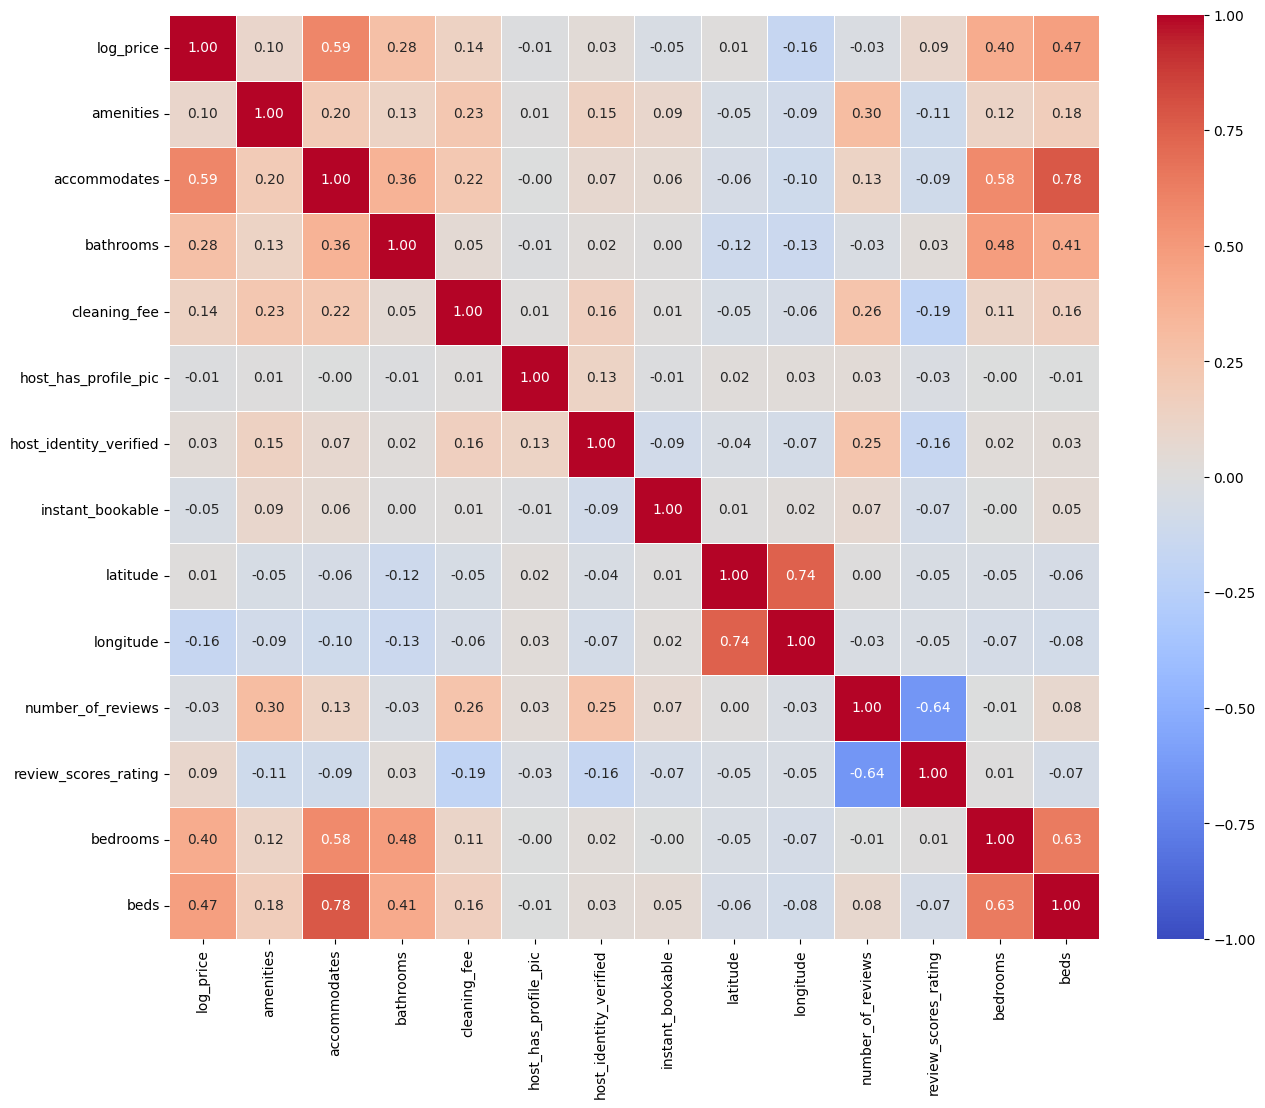

In [ ]:
_, ax = plt.subplots(figsize = (15, 12))
sns.heatmap(corr_matrix.toArray(), xticklabels = num_feats, yticklabels = num_feats, annot = True,
            fmt = '.2f', cmap = 'coolwarm', vmin = -1, vmax = 1, linewidth = .5, ax = ax)
plt.show()

<b>Outtakes:</b>
<ul>
<li>Beds and bedrooms are higly correlated, as expected, as well beds and accommodates.</li>
<li>Latitude and longitude are higly (positively) correlated.</li>
<li>The number of reviews is negatively correlated to the rating.</li>
</ul>

We select the features with higher correlation:

In [ ]:
corr_feats = ['beds', 'bathrooms', 'accomodates', 'cleaning_fee', 'longitude']

<h2>FEATURES PLOTS</h2>

To produce plots we select a random sample of data:

In [ ]:
if TRAIN_SIZE <= 10000:
  sample_df = train.toPandas()
else:
  sample_df = train.sample(10000/TRAIN_SIZE, seed = 7).toPandas()

In [ ]:
hist_feats = list(set(num_feats) & set(hc_feats))
train.select(hist_feats).dtypes

[('amenities', 'int'),
 ('review_scores_rating', 'double'),
 ('number_of_reviews', 'bigint'),
 ('beds', 'double'),
 ('log_price', 'double'),
 ('latitude', 'double'),
 ('bathrooms', 'double'),
 ('bedrooms', 'double'),
 ('accommodates', 'bigint'),
 ('longitude', 'double')]

<h4>Numerical features distribution</h4>

amenities
review_scores_rating
number_of_reviews
beds
log_price
latitude
bathrooms
bedrooms
accommodates
longitude


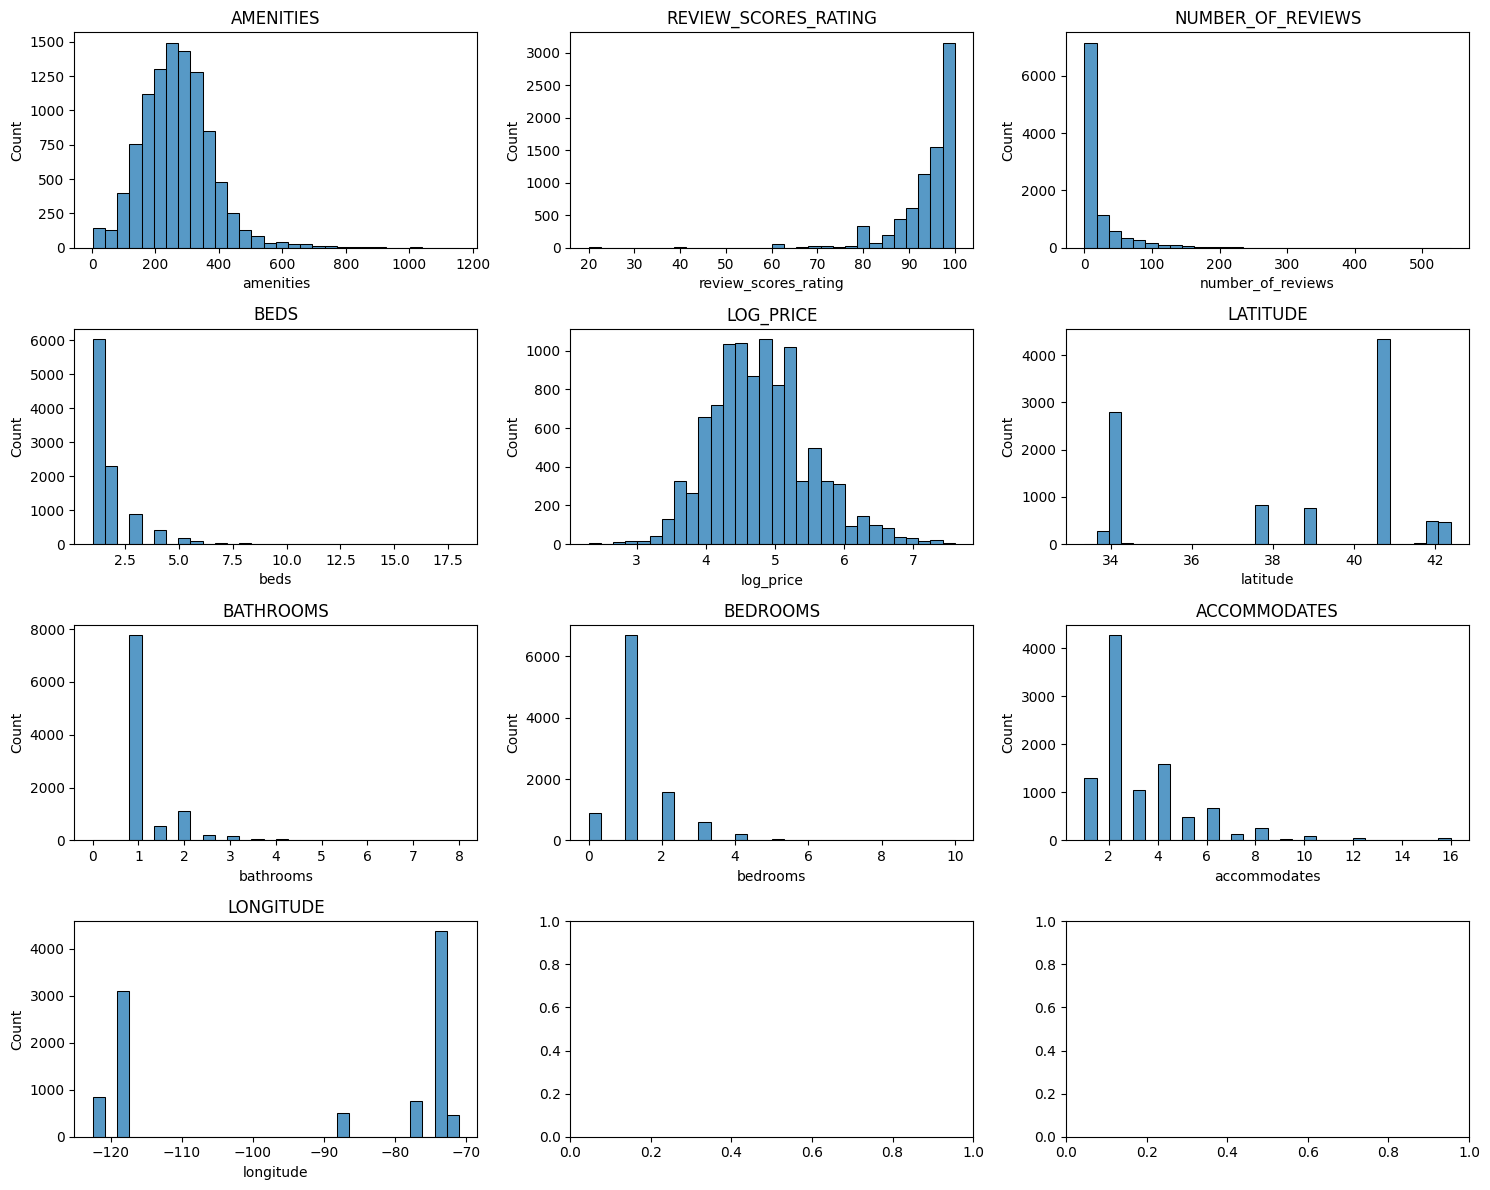

In [ ]:
hist_feats = list(set(num_feats) & set(hc_feats))
rows = int(np.ceil(len(hist_feats) / 3))
_, axes = plt.subplots(rows, 3, figsize = (15, 12))
for feat, ax in zip(hist_feats, axes.ravel()):
  print(feat)
  sns.histplot(data = sample_df, x = feat, bins = 30, ax = ax)
  ax.set_title(feat.upper())
plt.tight_layout()
plt.show()

<b>Outtakes:</b>
<ul>
<li>The target feature (log_price) has an almost-normal distribution, indicative of the log-transformation implicitly performed.</li>
<li>The longitude distribution shows how the data is related to houses from the US East and West coasts.</li>
<li>Beds have a prominent right tail, review_score_rating a prominent left tail.</li>
</ul>

<h4>Categorical features distribution</h4>

We plot the distribution of categorical features together with boxplots of the target feature for each class:

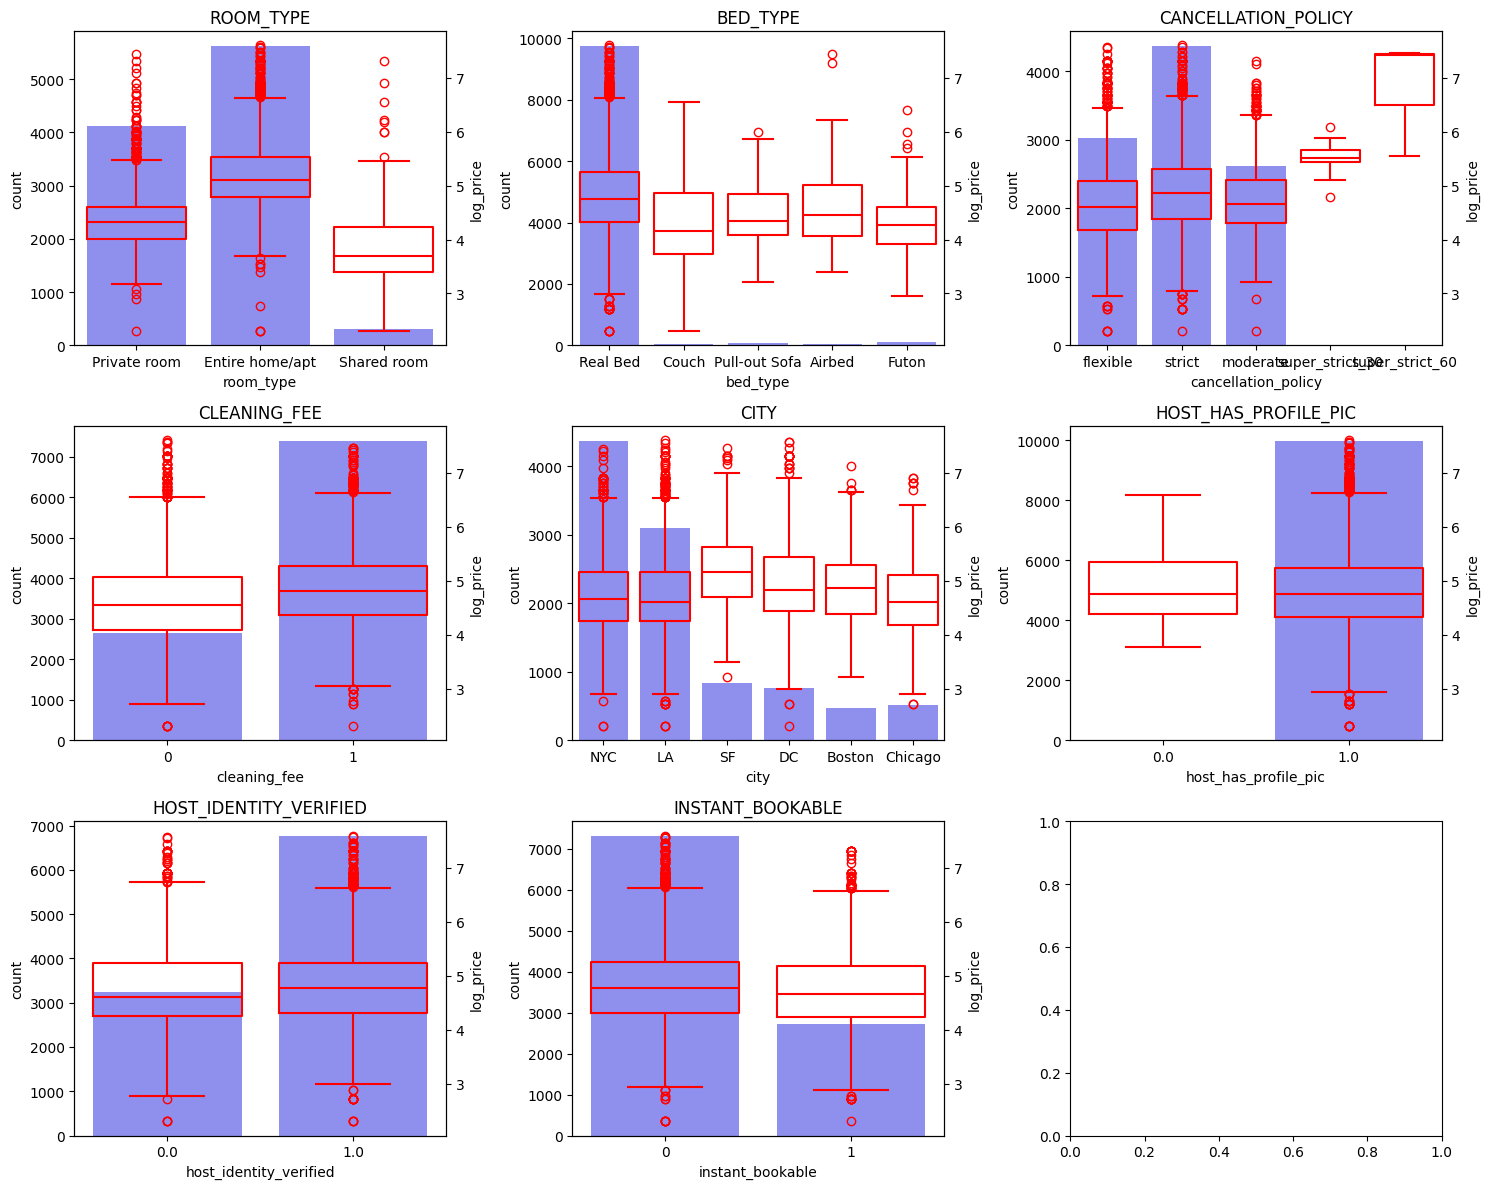

In [ ]:
rows = int(np.ceil(len(lc_feats) / 3))
_, axes = plt.subplots(rows, 3, figsize = (15, 12))
for feat, ax in zip(lc_feats, axes.ravel()):
  sns.countplot(data = sample_df, x = feat, color = 'blue', alpha = .5, ax = ax)
  ax2 = ax.twinx()
  sns.boxplot(data = sample_df, x = feat, y = 'log_price', color = 'red', fill = False, ax = ax2)
  ax.set_title(feat.upper())
plt.tight_layout()
plt.show()

<b>Outtakes:</b>
<ul>
<li>The vast majority of bed types is "Real Bed".</li>
<li>Almost all the hosts has a profile pic.</li>
<li>Room type, city and cancellation policy are the features with greater price variabilty among classes.</li>
</ul>

In [ ]:
cat_selected = ['city', 'host_identity_verified', 'instant_bookable', 'room_type', 'cancellation_policy']

<h2>MODELLING</h2>

Once we have selected the features to use for predictions it's worth considering again the issue of the missing values: note that now the percentages of missing values for each features is rather small  

In [ ]:
num_feats_m = ['beds', 'bathrooms', 'accommodates', 'longitude']
cat_feats_m = ['cleaning_fee', 'city', 'host_identity_verified', 'instant_bookable', 'room_type', 'cancellation_policy']

missing_vals_selected = train.select([round( (100/TRAIN_SIZE) * count(when(col(c).isNull() |
                         #isnan(c) |
                         (col(c) == '') |
                         col(c).contains('None') |
                         col(c).contains('NULL'), c)), 2).alias(c) for c in (num_feats_m + cat_feats_m)])
missing_vals_selected.show(truncate = False)

+----+---------+------------+---------+------------+----+----------------------+----------------+---------+-------------------+
|beds|bathrooms|accommodates|longitude|cleaning_fee|city|host_identity_verified|instant_bookable|room_type|cancellation_policy|
+----+---------+------------+---------+------------+----+----------------------+----------------+---------+-------------------+
|0.19|0.27     |0.0         |0.0      |0.0         |0.0 |0.28                  |0.0             |0.0      |0.0                |
+----+---------+------------+---------+------------+----+----------------------+----------------+---------+-------------------+



This suggest we can implement a simple imputing method, i.e. filling the missing values with the median or mode of each feature:

In [ ]:
beds_median = train.select('beds').agg({'beds' : 'median'}).first()[0]
bathrooms_median = train.select('bathrooms').agg({'bathrooms' : 'median'}).first()[0]
host_median = train.select('host_identity_verified').agg({'host_identity_verified' : 'mode'}).first()[0]

train_filled = train.select(*num_feats_m, *cat_feats_m, 'log_price')
train_filled = train_filled.na.fill({'beds' : beds_median, 'bathrooms' : bathrooms_median, 'host_identity_verified' : host_median})
train_filled.show(5, truncate = False)

+----+---------+------------+-------------------+------------+----+----------------------+----------------+---------------+-------------------+-----------------+
|beds|bathrooms|accommodates|longitude          |cleaning_fee|city|host_identity_verified|instant_bookable|room_type      |cancellation_policy|log_price        |
+----+---------+------------+-------------------+------------+----+----------------------+----------------+---------------+-------------------+-----------------+
|3.0 |1.5      |5           |-118.34807781140026|1           |LA  |1                     |0               |Private room   |strict             |4.553876891600541|
|5.0 |1.0      |9           |-118.15139494815222|1           |LA  |1                     |1               |Entire home/apt|flexible           |5.298317366548036|
|1.0 |2.0      |2           |-118.28244214248406|1           |LA  |0                     |1               |Private room   |strict             |4.07753744390572 |
|2.0 |1.0      |4           

As a check let's confirm there are no missing values:

In [ ]:
missing_vals_filled = train_filled.select([round( (100/TRAIN_SIZE) * count(when(col(c).isNull() |
                         (col(c) == '') |
                         col(c).contains('None') |
                         col(c).contains('NULL'), c)), 2).alias(c) for c in train_filled.columns])
missing_vals_filled.show(truncate = False)

+----+---------+------------+---------+------------+----+----------------------+----------------+---------+-------------------+---------+
|beds|bathrooms|accommodates|longitude|cleaning_fee|city|host_identity_verified|instant_bookable|room_type|cancellation_policy|log_price|
+----+---------+------------+---------+------------+----+----------------------+----------------+---------+-------------------+---------+
|0.0 |0.0      |0.0         |0.0      |0.0         |0.0 |0.0                   |0.0             |0.0      |0.0                |0.0      |
+----+---------+------------+---------+------------+----+----------------------+----------------+---------+-------------------+---------+



As for preprocessing we only consider one pipeline, defined by Standard scaling for numerical features and One Hot Encoding for categorical features:

In [ ]:

num_feats_m = ['beds', 'bathrooms', 'accommodates', 'longitude']
cat_feats_m = ['cleaning_fee', 'city', 'host_identity_verified', 'instant_bookable', 'room_type', 'cancellation_policy']


num_vector_assembler = MFT.VectorAssembler(inputCols = num_feats_m, outputCol = 'num_vector')
num_vector_scaler = MFT.StandardScaler(inputCol = 'num_vector', outputCol = 'num_scaled', withMean = True, withStd = True)

cat_feats_idx = [c + '_idx' for c in cat_feats_m]
cat_indexer = MFT.StringIndexer(inputCols = cat_feats_m, outputCols = cat_feats_idx)
cat_feats_ohe = [c + '_ohe' for c in cat_feats_idx]
cat_encoder = MFT.OneHotEncoder(inputCols = cat_feats_idx, outputCols = cat_feats_ohe)

final_assembler = MFT.VectorAssembler(inputCols = ['num_scaled'] + cat_feats_ohe, outputCol = 'features')

preprocessor_dict = {'base' : [num_vector_assembler, num_vector_scaler, cat_indexer, cat_encoder, final_assembler]}


As for ML algorithms we consider three regression models:
<ul>
<li>Linear Regression: making predictions with linear function.</li>
<li>Random Forest: making predictions with an ensemble of decision trees.</li>
<li>Gradient Boosting: making predictions with an ensemble of weak learners like Random Forest, but using boosting (instead of bagging), that is the learnes are not in parallel, but they work in a sequence, each one fitting on the residuals of the previous one.</li>
</ul>

In [ ]:
#LINEAR REGRESSION
lr = LinearRegression(featuresCol = 'features', labelCol = 'log_price', predictionCol = 'prediction')
paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .addGrid(lr.fitIntercept, [False, True])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0]).build()

#RANDOM FOREST
rfr = RandomForestRegressor(featuresCol = 'features', labelCol = 'log_price', predictionCol = 'prediction')
paramGrid_rfr = ParamGridBuilder()\
          .addGrid(rfr.numTrees,  [50, 75, 100])\
          .addGrid(rfr.maxDepth, [5, 8])\
          .addGrid(rfr.minInstancesPerNode, [1, 3, 5]).build()

#GRADIENT BOOSTING
gbt = GBTRegressor(featuresCol = 'features', labelCol = 'log_price', predictionCol = 'prediction')
paramGrid_gbt = ParamGridBuilder()\
          .addGrid(gbt.maxDepth, [5, 8])\
          .addGrid(gbt.minInstancesPerNode, [1, 3, 5]).build()

model_dict = {'LR' : lr, 'RFR' : rfr, 'GBT' : gbt}
paramGrid_dict = {'LR' : paramGrid_lr, 'RFR' : paramGrid_rfr, 'GBT' : paramGrid_gbt}

For evaluation we consider the root mean squared error:

In [ ]:
evaluator = RegressionEvaluator(
    labelCol="log_price", predictionCol="prediction", metricName="rmse")

Finally for convenience we write a function which takes all possible preprocessing stages, models and hyperparameters grid and performs cross validation over all of them:

In [ ]:
def grid_train(train, preprocessor_dict, model_dict, paramGrid_dict, evaluator):
  estimator_keys = ['-'.join(item) for item in list(itertools.product(preprocessor_dict.keys(), model_dict.keys()))]
  results_df = pd.DataFrame(data = {'Estimator' : estimator_keys ,'Best_Score' : np.zeros(len(estimator_keys)),
                                                 'Best_Params' : np.empty(len(estimator_keys), dtype = object), 'Training_Time' : np.zeros(len(estimator_keys))})
  for prep_key, preprocessor in preprocessor_dict.items():
    for model_key, model in model_dict.items():
      print(prep_key.upper() + ' - ' + model_key.upper())
      estimator = Pipeline(stages = [*preprocessor, model])
      start = time.time()
      cv = CrossValidator(estimator = estimator, estimatorParamMaps = paramGrid_dict[model_key], evaluator = evaluator)
      cvModel = cv.fit(train)
      stop = time.time()
      results_df.loc[results_df['Estimator'] == '-'.join([prep_key, model_key]), 'Best_Score'] = cvModel.avgMetrics[0]
      results_df.loc[results_df['Estimator'] == '-'.join([prep_key, model_key]), 'Best_Params'] = str(cvModel.bestModel.stages[-1].extractParamMap())
      results_df.loc[results_df['Estimator'] == '-'.join([prep_key, model_key]), 'Training_Time'] = stop - start
      print('Best score: ', cvModel.avgMetrics[0])
      print('Best params: ', cvModel.bestModel.stages[-1].extractParamMap())
      print('Time: ', stop - start)
  display(results_df)
  return results_df

As a result we see that Gradient Boost slightly outperform random forest, and both beat linear regresion:

In [ ]:
results_df = grid_train(train = train_filled, preprocessor_dict = preprocessor_dict, model_dict = model_dict, paramGrid_dict = paramGrid_dict, evaluator = evaluator)

BASE - LR
Best score:  0.6344943189401614
Best params:  {Param(parent='LinearRegression_142059baccc1', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LinearRegression_142059baccc1', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LinearRegression_142059baccc1', name='epsilon', doc='The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber'): 1.35, Param(parent='LinearRegression_142059baccc1', name='featuresCol', doc='features column name.'): 'features', Param(parent='LinearRegression_142059baccc1', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LinearRegression_142059baccc1', name='labelCol', doc='label column name.'): 'log_price', Param(parent='LinearRegression_142059baccc1', name='loss', doc='The loss function to be optimized. Su

,Estimator,Best_Score,Best_Params,Training_Time
0,base-LR,0.634494,"{Param(parent='LinearRegression_142059baccc1',...",215.598781
1,base-RFR,0.481603,{Param(parent='RandomForestRegressor_cc28a0c58...,1107.262584
2,base-GBT,0.448164,"{Param(parent='GBTRegressor_f4117be87db0', nam...",1134.373303


<h2>Test evaluation</h2>

Finally let's check the model performance on the testing dataset, first we impute missing values:

In [ ]:
test_filled = test.select(*num_feats_m, *cat_feats_m, 'log_price')
test_filled = test_filled.na.fill({'beds' : beds_median, 'bathrooms' : bathrooms_median, 'host_identity_verified' : host_median})
test_filled.show(5, truncate = False)

+----+---------+------------+-------------------+------------+----+----------------------+----------------+---------------+-------------------+------------------+
|beds|bathrooms|accommodates|longitude          |cleaning_fee|city|host_identity_verified|instant_bookable|room_type      |cancellation_policy|log_price         |
+----+---------+------------+-------------------+------------+----+----------------------+----------------+---------------+-------------------+------------------+
|4.0 |1.0      |10          |-73.93596565003554 |1           |NYC |1                     |0               |Entire home/apt|strict             |5.416100402204419 |
|3.0 |1.0      |4           |-73.96422476030648 |1           |NYC |1                     |0               |Entire home/apt|strict             |5.105945473900579 |
|1.0 |1.0      |2           |-118.4743844323845 |1           |LA  |1                     |1               |Entire home/apt|strict             |5.010635294096256 |
|1.0 |1.0      |4     

Then train a gradient boosting estimator with the parameters suggested by the grid search and evaluate the prediction on the test DataFrame:

In [ ]:
gbt_best = GBTRegressor(featuresCol = 'features', labelCol = 'log_price', predictionCol = 'prediction',
                        maxDepth = 5, minInstancesPerNode = 3)
estimator_best = Pipeline(stages = [*preprocessor_dict['base'], gbt_best])
estimator_best_fit = estimator_best.fit(train_filled)
test_predictions = estimator_best_fit.transform(test_filled)
rmse_test = evaluator.evaluate(test_predictions)
print('Testing RMSE: ', rmse_test)

Testing RMSE:  0.4454905792701899
